# Introduction

![Example of Transfer Learning with YAMNet](Images\TransferLearningWithPretrainedAudioNetworksExample_01.png)

https://www.featureform.com/post/the-definitive-guide-to-embeddings

https://www.pinecone.io/learn/vector-embeddings/

https://vaclavkosar.com/ml/Embeddings-in-Machine-Learning-Explained

Audio recordings can be transformed into vectors using image embedding transformations over the audio frequencies visual representation (e.g., using its Spectrogram).

Uses frames that are 0.96 seconds long and extracts one frame every 0.48 seconds.

Accepts a 1-D float32 Tesnor or NumPy array -> single-channel 16kHz samples in range [-1.0, +1.0]

Returns 3 outputs -> class scores, embeddings and log mel spectrogram

https://tfhub.dev/google/yamnet/1

https://developers.google.com/codelabs/tflite-audio-classification-custom-model-android#2 -> Look at this for mobile app deployment

https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files


    An embedding is a mapping from discrete objects, such as words, to vectors of real numbers.

    The individual dimensions in these vectors typically have no inherent meaning. Instead, it’s the overall patterns of location and distance between vectors that machine learning takes advantage of.


In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [3]:
!pip install tensorflow-hub

In [4]:
!pip install tensorflow-io

In [5]:
!pip install pydub

# TensorFlow imports & GPU Test


In [6]:
import sys

def get_base_prefix_compat():
    """Get base/real prefix, or sys.prefix if there is none."""
    return getattr(sys, "base_prefix", None) or getattr(sys, "real_prefix", None) or sys.prefix

def in_virtualenv():
    return get_base_prefix_compat() != sys.prefix

In [7]:
in_virtualenv()

False

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [9]:

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# Imports



In [10]:
import sys

import os
import logging
import io 

import pydub

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from pydub import AudioSegment
from pydub.utils import make_chunks
from IPython import display
from collections import namedtuple
from datetime import datetime 
from pathlib import Path
from sklearn import preprocessing

# Uncomment this if using google colab 
#from google.colab import files

T:\Anaconda\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Glossary

YAMNet -> pre-trained neural network that employs the Mobilenet_v1 depthwise-seperable convolution architecture


### Pre-processing - If Local

## Only run this once!


I wil be using Tensorflows ***tf.keras.utils.audio_dataset_from_directory*** feature to create dataset labels and import them into my program.

In order to do this effectively I will need subdirectories of each chord along with its chord type. 

I will then use a python segment to extract 2 seconds of audio from each file and place them in their relevant folders. 

Modified Code from: https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files

https://stackoverflow.com/questions/36799902/how-to-splice-an-audio-file-wav-format-into-1-sec-splices-in-python

273 Guitar classes per file (272 due to 0 indexing)
6 Guitar Recordings

272 * 6 = 1632 Overall Recordings 

3 voicings for each one recording


In [11]:
IDMT_chords = ["Emaj","Fmaj","F#maj","Gmaj",
               "G#maj","Amaj","A#maj","Bmaj",
               "Cmaj","C#maj","Dmaj","D#maj",
               "Emin","Fmin","F#min","Gmin",
               "G#min","Amin","A#min","Bmin",
               "Cmin","C#min","Dmin","D#min",
               "Emaj7","Fmaj7","F#maj7","Gmaj7",
               "G#maj7","Amaj7","A#maj7","Bmaj7",
               "Cmaj7","C#maj7","Dmaj7","D#maj7",
               "Emin7","Fmin7","F#min7","Gmin7",
               "G#min7","Amin7","A#min7","Bmin7",
               "Cmin7","C#min7","Dmin7","D#min7",
               "D5","D#5","E5","F5","F#5","G5","G#5",
               "A5","A#5","B5","C5","C#5","E7","F7","F#7","G7",
               "G#7","A7","A#7","B7","C7","C#7","D7","D#7","Ahdim7",
               "A#hdim7","Bhdim7","Chdim7","C#hdim7","Dhdim7",
               "D#hdim7","Ehdim7","Fhdim7","F#hdim7","Ghdim7","G#hdim7"]

In [12]:
len(IDMT_chords)

84

In [13]:
def multiple_splits(chunks, chords, folder, iteration):
    for i in range(len(chords)):
            print(i)
            chunk_name = f"{chords[i]}"
            print(chunk_name)
            chunks[i].export(f"{folder}\{chunk_name}_{i}_{iteration}.wav", format="wav")
    print(f"Finished Loop {iteration}")


In [14]:
wav_files  = ['T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\garageband_guitar_Acoustic_Guitar.wav',
             'T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\garageband_guitar_Hard_Rock.wav',
             'T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\garageband_guitar_Classic_Clean.wav',
             'T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\\at_live_guitar_Campfire.wav',
             'T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\\at_live_guitar_Guitar_Open.wav',
             'T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\\at_live_guitar_Nylon_Concerto_Guitar.wav']

source_folder = 'T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chords'

audio = []
chunks = []

for i in range(0, len(wav_files)):
    print(wav_files[i])
    audio.append(AudioSegment.from_wav(wav_files[i]))



for i in range(0, len(audio)):
    chunks.append(make_chunks(audio[i], 2000))
    
    
    
## Run Function
for i in range(0, len(wav_files)):
    multiple_splits(chunks[i], IDMT_chords, source_folder, i)

# print("Finished exporting all files")



    

T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\garageband_guitar_Acoustic_Guitar.wav
T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\garageband_guitar_Hard_Rock.wav
T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\garageband_guitar_Classic_Clean.wav
T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\at_live_guitar_Campfire.wav
T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\at_live_guitar_Guitar_Open.wav
T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\at_live_guitar_Nylon_Concerto_Guitar.wav
0
Emaj
1
Fmaj
2
F#maj
3
Gmaj
4
G#maj
5
Amaj
6
A#maj
7
Bmaj
8
Cmaj
9
C#maj
10
Dmaj
11
D#maj
12
Emin
13
Fmin
14
F#min
15
Gmin
16
G#min
17
Amin
18
A#min
19
Bmin
20
Cmin
21
C#min
22
Dmin
23
D#min
24
Emaj7
25
Fmaj7
26
F#maj7
27
Gmaj7
28
G#maj7
29
Amaj7
30
A#maj7
31
Bmaj7
32
Cmaj7
33
C#maj7
34
Dmaj7
35
D#maj7
36
Emin7
37
Fmin7
38
F#min7
39
Gmin7
40
G#min7
41
Amin7
42
A#min7
43
Bmin7
44
Cmin7
45
C#min7
46
Dmin7
47
D#min7
48
D5
49
D#5
50
E5
51
F5
52
F#5
53
G5
54
G#5
55
A5
56
A#5
57
B5
58
C5
59
C#5
60
E7
61
F7
62
F#7
63
G7
64
G#7
65
A7
66
A#7
67

In [15]:
File = namedtuple('ChordList', 'filenames targets')

In [16]:
files = []

path = Path('T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chords')

for item in path.glob('**/*'):
    if item.suffix in ['.wav']:
        filenames = str(Path.resolve(item))
        targets = str((os.path.basename(item)).split('_')[0])
        
        files.append(File(filenames, targets))

In [17]:
chord_dataframe = pd.DataFrame(files)

In [18]:
chord_dataframe

,filenames,targets
0,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5
1,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5
2,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5
3,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5
4,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5
...,...,...
2065,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin
2066,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin
2067,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin
2068,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin


In [19]:
le = preprocessing.LabelEncoder()
label_encoded_df = chord_dataframe.copy()
encoded_labels = le.fit_transform(label_encoded_df['targets'])
label_encoded_df = label_encoded_df.assign(labels=encoded_labels)
        

In [20]:
label_encoded_df

,filenames,targets,labels
0,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5,0
1,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5,0
2,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5,0
3,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5,0
4,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,A#5,0
...,...,...,...
2065,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin,82
2066,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin,82
2067,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin,82
2068,T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\guitar\Chor...,Gmin,82


In [22]:
label_encoded_df.to_csv('T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\chords_csv_new.csv', index=False)

### Dataset
The dataset I have chosen to use is the **IDMT-SMT-CHORDS** dataset for prediciting chords.

For prediciting progressions (or at least suggesting) I am using 
**IDMT-SMT-CHORD-SEQUENCES**.

Both datasets can be found @ :

https://www.idmt.fraunhofer.de/en/publications/datasets/chord-sequences.html

https://www.idmt.fraunhofer.de/en/publications/datasets/chords.html

---


### Loading YAMNet from TensorFlow Hub

https://www.tensorflow.org/hub/tutorials/yamnet


In [23]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [24]:
testing_wav_file_name = 'T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\Gminup.wav'

print(testing_wav_file_name)

T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\Gminup.wav


In [25]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


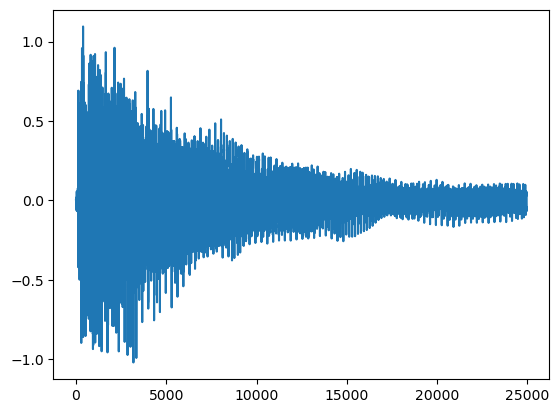

In [26]:
testing_wav_data =  load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)


### IDMT Dataset Loading

The IDMT-SMT-CHORDS comprises of 16 MIDI generated audio files consists of various chord classes. Here we focused on chord voicings, which are commonly used on keyboard instruments and guitars. Based on this we categorized as Guitar and Non-Guitar instruments. We used several software instruments from Ableton Live and Garage Band to synthesize these MIDI files with various instruments such as piano, synthesizer pad, as well as acoustic and electric guitar.


https://www.idmt.fraunhofer.de/en/publications/datasets/chords.html


https://blog.paperspace.com/how-to-maximize-gpu-utilization-by-finding-the-right-batch-size/

I will split the data into Training:Testing:Validation in the ratio 70:10:20 DOUBLE CHECK

I will start with batch size 32 and if time permits I will graph out accuracies at various batch sizes

For reproducibility of input data I will set seed to 1903 bd

Yamnet only accepts mono audio at 16Khz samples in range -1, +1

During this process I also consulted the following website:
https://www.tensorflow.org/tutorials/audio/simple_audio

Quite luckily the data constraints are very similar to the dataset I am using, so code can be recycled

In [27]:
filenames = label_encoded_df['filenames']
labels = label_encoded_df['labels']

In [28]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
2065    82
2066    82
2067    82
2068    82
2069    82
Name: labels, Length: 2070, dtype: int32

In [29]:
IDMT_train =  tf.data.Dataset.from_tensor_slices((filenames, labels))
IDMT_train.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [30]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

IDMT_train = IDMT_train.map(load_wav_for_map)
IDMT_train.element_spec


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

The data only has mono audio so we should drop the additional axis in our array

### Explore the data


### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Above has been kept the same

In [31]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings, tf.repeat(label, num_embeddings))


In [32]:

# extract embedding
IDMT_train = IDMT_train.map(extract_embedding).unbatch()
IDMT_train.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [33]:
print(IDMT_train.cardinality())

tf.Tensor(-2, shape=(), dtype=int64)


### Splitting the data

Since I'm using tensorflow version 2.10 - I will be using https://www.tensorflow.org/api_docs/python/tf/keras/utils/split_dataset OR https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

Ratio -> 80:10:10

In [36]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.9,  test_split=0.05, val_split=0.05, shuffle=True):
    assert(train_split + test_split + val_split) == 1
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(buffer_size = 10000, seed=1903, reshuffle_each_iteration=False)
    
    train_size = int(train_split * ds_size)
    print(f"train size: {train_size}")
    val_size = int(val_split * ds_size)
    print(f"val size: {val_size}")
    test_size = int(test_split * ds_size)
    print(f"test size: {test_size}")

    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(val_size)
    test_ds = test_ds.take(test_size)

    
    return train_ds, val_ds, test_ds

In [37]:
cached_ds = IDMT_train.cache()

In [38]:
ds_size = cached_ds.reduce(0, lambda x,_: x+1).numpy()

In [39]:
ds_size

8280

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(cached_ds,
                                                      ds_size
                                                      )

train size: 7452
val size: 414
test size: 414


In [41]:
length_test = test_ds.reduce(0, lambda x,_: x+1).numpy()
length_val = val_ds.reduce(0, lambda x,_: x+1).numpy()
length_train = train_ds.reduce(0, lambda x,_: x+1).numpy()
print(length_test)
print(length_val)
print(length_train)

414
414
7452


In [42]:
vals = np.unique(np.fromiter(train_ds.map(lambda x, y: y), float), return_counts=True)

for val, count in zip(*vals):
    print(int(val), count)

0 87
1 82
2 81
3 66
4 84
5 85
6 89
7 112
8 105
9 105
10 86
11 90
12 112
13 107
14 88
15 88
16 87
17 64
18 88
19 91
20 85
21 82
22 87
23 89
24 66
25 88
26 86
27 92
28 81
29 83
30 78
31 62
32 110
33 81
34 85
35 90
36 87
37 83
38 65
39 85
40 86
41 89
42 130
43 106
44 88
45 84
46 89
47 108
48 110
49 87
50 106
51 105
52 86
53 109
54 106
55 108
56 85
57 85
58 88
59 61
60 87
61 88
62 86
63 80
64 86
65 108
66 66
67 107
68 88
69 91
70 90
71 92
72 85
73 65
74 90
75 87
76 87
77 92
78 86
79 89
80 67
81 83
82 89
83 85


In [43]:
vals = np.unique(np.fromiter(val_ds.map(lambda x, y: y), float), return_counts=True)

for val, count in zip(*vals):
    print(int(val), count)

0 2
1 7
2 11
3 2
4 3
5 6
6 3
7 4
8 9
9 6
10 3
11 5
12 3
13 9
14 4
15 4
16 5
17 5
18 5
19 2
20 5
21 5
22 5
23 3
24 2
25 7
26 4
27 3
28 10
29 8
30 5
31 7
32 3
33 7
34 5
35 4
36 5
37 7
38 4
39 4
40 4
41 2
42 9
43 10
44 4
45 7
46 4
47 4
48 2
49 7
50 6
51 8
52 3
53 6
54 7
55 9
56 6
57 8
58 4
59 7
60 8
61 3
62 5
63 6
64 5
65 6
66 1
67 9
68 3
69 2
70 2
71 2
72 5
73 4
74 1
75 5
76 3
78 5
79 3
80 1
81 8
82 4
83 5


In [44]:
train_ds = train_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [45]:
length_train = train_ds.reduce(0, lambda x,_: x+1).numpy()
length_test = test_ds.reduce(0, lambda x,_: x+1).numpy()
length_val = val_ds.reduce(0, lambda x,_: x+1).numpy()
print(length_test)
print(length_val)
print(length_train)

13
13
233


In [46]:
tf.data.experimental.cardinality(test_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=-2>

In [47]:
train_ds.element_spec


(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [48]:
val_ds.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [49]:
test_ds.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Create Model


In [50]:
my_classes =["A#5","A#7","A#hdim7","A#maj7","A#maj","A#min7","A#min","A5","A7","Ahdim7","Amaj7","Amaj","Amin7","Amin","B5","B7","Bhdim7","Bmaj7","Bmaj","Bmin7","Bmin","C#5","C#7","C#hdim7","C#maj7","C#maj","C#min7","C#min","C5","C7","Chdim7","Cmaj7","Cmaj","Cmin7","Cmin","D#5","D#7","D#hdim7","D#maj7","D#maj","D#min7","D#min","D5","D7","Dhdim7","Dmaj7","Dmaj","Dmin7","Dmin","E5","E7","Ehdim7","Emaj7","Emaj","Emin7","Emin","F#5","F#7","F#hdim7","F#maj7","F#maj","F#min7","F#min","F5","F7","Fhdim7","Fmaj7","Fmaj","Fmin7","Fmin","G#5","G#7","G#hdim7","G#maj7","G#maj","G#min7","G#min","G5","G7","Ghdim7","Gmaj7","Gmaj","Gmin7","Gmin"]

In [51]:
len(my_classes)

84

In [52]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),

    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 84)                430

In [53]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])



In [54]:
history = my_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds)

Epoch 1/100
233/233 [==============================] - 2s 5ms/step - loss: 7.1091 - accuracy: 0.0123 - val_loss: 4.4095 - val_accuracy: 0.0314
Epoch 2/100
233/233 [==============================] - 1s 4ms/step - loss: 5.9341 - accuracy: 0.0195 - val_loss: 4.4529 - val_accuracy: 0.0242
Epoch 3/100
233/233 [==============================] - 1s 4ms/step - loss: 5.3405 - accuracy: 0.0212 - val_loss: 4.5315 - val_accuracy: 0.0338
Epoch 4/100
233/233 [==============================] - 1s 4ms/step - loss: 4.9956 - accuracy: 0.0244 - val_loss: 4.5035 - val_accuracy: 0.0459
Epoch 5/100
233/233 [==============================] - 1s 4ms/step - loss: 4.7510 - accuracy: 0.0274 - val_loss: 4.4554 - val_accuracy: 0.0362
Epoch 6/100
233/233 [==============================] - 1s 4ms/step - loss: 4.6027 - accuracy: 0.0306 - val_loss: 4.4407 - val_accuracy: 0.0531
Epoch 7/100
233/233 [==============================] - 1s 4ms/step - loss: 4.4889 - accuracy: 0.0349 - val_loss: 4.6350 - val_accuracy: 0.0531

Epoch 58/100
233/233 [==============================] - 1s 4ms/step - loss: 3.9150 - accuracy: 0.0801 - val_loss: 4.7461 - val_accuracy: 0.0676
Epoch 59/100
233/233 [==============================] - 1s 4ms/step - loss: 3.8924 - accuracy: 0.0813 - val_loss: 4.6449 - val_accuracy: 0.0580
Epoch 60/100
233/233 [==============================] - 1s 4ms/step - loss: 3.8989 - accuracy: 0.0820 - val_loss: 4.6506 - val_accuracy: 0.0676
Epoch 61/100
233/233 [==============================] - 1s 4ms/step - loss: 3.8960 - accuracy: 0.0751 - val_loss: 4.6702 - val_accuracy: 0.0676
Epoch 62/100
233/233 [==============================] - 1s 4ms/step - loss: 3.9037 - accuracy: 0.0840 - val_loss: 4.6247 - val_accuracy: 0.0628
Epoch 63/100
233/233 [==============================] - 1s 4ms/step - loss: 3.9051 - accuracy: 0.0764 - val_loss: 4.6934 - val_accuracy: 0.0652
Epoch 64/100
233/233 [==============================] - 1s 4ms/step - loss: 3.8848 - accuracy: 0.0839 - val_loss: 4.8137 - val_accuracy:

In [55]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

13/13 [==============================] - 0s 2ms/step - loss: 3.9230 - accuracy: 0.0870
Loss:  3.9229869842529297
Accuracy:  0.08695652335882187


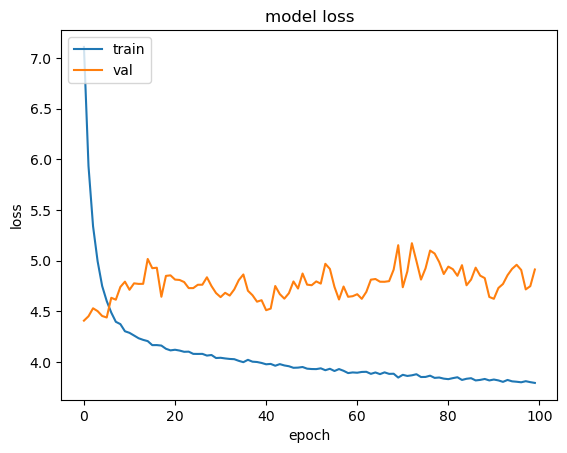

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

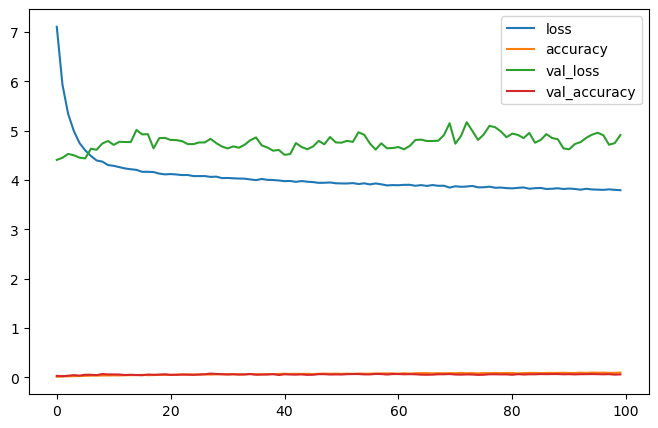

In [57]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [58]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')
print(result.mean(axis=0).argmax())
print(len(result.mean(axis=0)))

The main sound is: Amin
13
84
